# Load the dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


def get_datasets(num_epochs, batch_size):
    """Load CIFAR dataset into memory"""

    train_ds: tf.data.Dataset = tfds.load("cifar10", split="train")
    test_ds: tf.data.Dataset = tfds.load("cifar10", split="test")


    train_ds = train_ds.map(
        lambda sample: {
            'image': tf.cast(sample['image'], tf.float32) / 255.,
            'label': sample['label']
        }
    )

    test_ds = test_ds.map(
        lambda sample: {
            'image': tf.cast(sample['image'], tf.float32) / 255.,
            'label': sample['label']
        }
    )

    train_ds = train_ds.repeat().shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).take(num_epochs).prefetch(1)

    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, test_ds

In [2]:
input_shape = (32,32,3)
num_epochs = 10_000
batch_size = 32

train_ds, test_ds = get_datasets(num_epochs, batch_size)
assert train_ds.take(1).element_spec['image'].shape[1:] == input_shape

# Define the model

In [3]:
import jax
from flax import nnx

import functools
import itertools
from typing import Sequence, Callable


compose = lambda *fs: functools.reduce(lambda f, g: lambda x: g(f(x)), fs)
flatten = lambda x: x.reshape(batch_size, 1,-1).squeeze()

class CNN(nnx.Module):
    """A simple CNN classifier"""

    def __init__(self,
                 dim_in,
                 dim_out,
                *,
                activation: Callable,
                rngs: nnx.Rngs):

        self.layers = [
            # in_features ~ num_channels
            # out_feature ~ num_filters

            nnx.Conv(in_features=dim_in, out_features=32, kernel_size=(3, 3), strides=1, padding="SAME", rngs=rngs),
            nnx.BatchNorm(num_features=32, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            nnx.Conv(in_features=32, out_features=32, kernel_size=(3,3), strides=2, padding="SAME", rngs=rngs),
            nnx.BatchNorm(num_features=32, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            nnx.Conv(in_features=32, out_features=64, kernel_size=(3,3), strides=1, padding="SAME", rngs=rngs),
            nnx.BatchNorm(num_features=64, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            nnx.Conv(in_features=64, out_features=64, kernel_size=(3,3), strides=2, padding="SAME", rngs=rngs),
            nnx.BatchNorm(num_features=64, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            flatten,
            nnx.Linear(in_features=8*8*64, out_features=128, rngs=rngs),
            nnx.BatchNorm(num_features=128, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            nnx.Dropout(rate=0.5, rngs=rngs),
            nnx.Linear(in_features=128, out_features=dim_out, rngs=rngs),
            nnx.softmax

        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*itertools.chain(self.layers))(x)


In [4]:
import operator

rngs = nnx.Rngs(0)
activation = nnx.relu
dim_in = 3    # RGB channels
dim_out = 10  # Num classes

model = CNN(dim_in, dim_out, activation=activation, rngs=rngs)
nnx.display(model)

W0000 00:00:1733019352.122594 6727493 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1733019352.140555 6727493 service.cc:145] XLA service 0x16e018c60 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733019352.140566 6727493 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1733019352.141781 6727493 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1733019352.141792 6727493 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

CNN(
  layers=[Conv(
    kernel_shape=(3, 3, 3, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 3, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=3,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x16deb4860>,
    bias_init=<function zeros at 0x1648323e0>,
    conv_general_dilated=<function conv_general_dilated at 0x16424f380>
  ), BatchNorm(
    mean=BatchStat(
      value=Array(shape=(32,), dtype=float32)
    ),
    var=BatchStat(
      value=Array(shape=(32,), dtype=float32)
    ),
    scale=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bia

# Checking the model

In [5]:
import jax.numpy as jnp

model(jnp.ones([batch_size, *input_shape])).shape

(32, 10)

# Create the optimizer and define some metrics

In [6]:
import optax

learning_rate = 0.0005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adam(learning_rate, momentum))
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average("loss")
)
nnx.display(metrics)

MultiMetric(
  accuracy=Accuracy(
    argname='values',
    total=MetricState(
      value=Array(0., dtype=float32)
    ),
    count=MetricState(
      value=Array(0, dtype=int32)
    )
  ),
  loss=Average(
    argname='loss',
    total=MetricState(
      value=Array(0., dtype=float32)
    ),
    count=MetricState(
      value=Array(0, dtype=int32)
    )
  )
)


# Define training steps

In [7]:
def loss_fn(model: CNN, batch):
    logits = model(batch["image"])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch["label"]
    ).mean()
    return loss, logits

In [8]:
@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["label"])
    optimizer.update(grads)

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["label"])

# Train and evaluate the model

In [9]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}

eval_every = 200

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == num_epochs - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f"train_{metric}"].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print(
      f"[train] step: {step}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"[test] step: {step}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

[train] step: 200, loss: 2.1574249267578125, accuracy: 31.45211410522461
[test] step: 200, loss: 2.0940442085266113, accuracy: 38.341346740722656
[train] step: 400, loss: 2.0777390003204346, accuracy: 40.25
[test] step: 400, loss: 2.0403082370758057, accuracy: 43.85015869140625
[train] step: 600, loss: 2.0245585441589355, accuracy: 45.5625
[test] step: 600, loss: 2.0066449642181396, accuracy: 46.99519348144531
[train] step: 800, loss: 1.9997303485870361, accuracy: 47.671875
[test] step: 800, loss: 1.9826613664627075, accuracy: 50.06009292602539
[train] step: 1000, loss: 1.9619250297546387, accuracy: 51.671875
[test] step: 1000, loss: 1.9590610265731812, accuracy: 51.69270706176758
[train] step: 1200, loss: 1.9563183784484863, accuracy: 52.125
[test] step: 1200, loss: 1.9408434629440308, accuracy: 53.62580490112305
[train] step: 1400, loss: 1.9340728521347046, accuracy: 54.203121185302734
[test] step: 1400, loss: 1.9280072450637817, accuracy: 54.346954345703125
[train] step: 1600, loss:

# Visualize the metrics

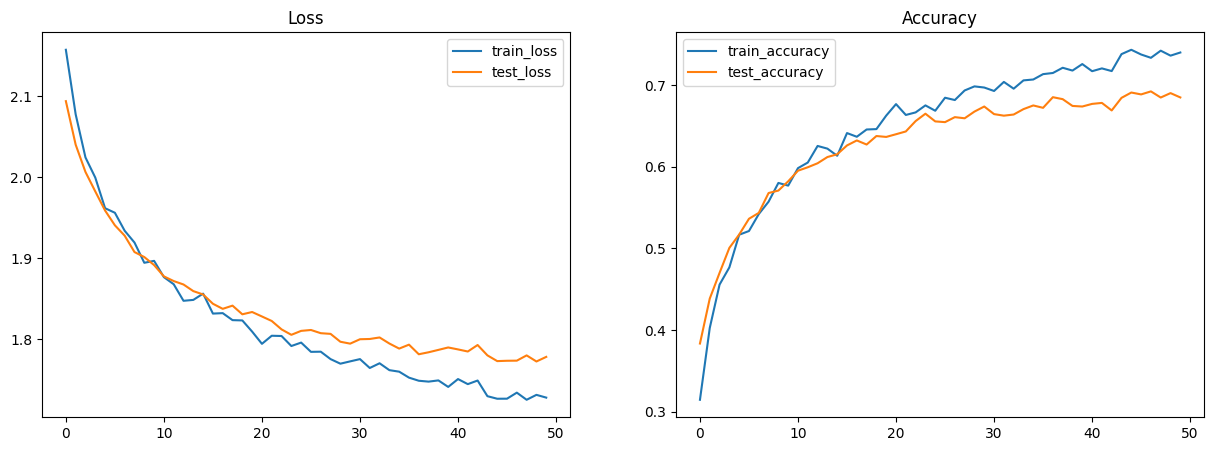

In [10]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

# Perform inference on the test set

In [11]:
model.eval() # Switch to evaluation mode.

@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

In [12]:
import numpy as np

CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

In [13]:
test_batch = test_ds.as_numpy_iterator().next()
pred = CLASSES[pred_step(model, test_batch)]
pred

array(['ship', 'deer', 'airplane', 'ship', 'cat', 'bird', 'truck', 'deer',
       'airplane', 'dog', 'airplane', 'frog', 'truck', 'bird', 'dog',
       'automobile', 'dog', 'horse', 'ship', 'bird', 'automobile', 'deer',
       'bird', 'dog', 'frog', 'horse', 'cat', 'automobile', 'horse',
       'horse', 'airplane', 'deer'], dtype='<U10')

In [14]:
#actual = CLASSES[]

actual = CLASSES[test_batch["label"]]
actual

array(['dog', 'deer', 'airplane', 'ship', 'bird', 'bird', 'automobile',
       'deer', 'airplane', 'cat', 'airplane', 'frog', 'truck', 'cat',
       'cat', 'automobile', 'dog', 'horse', 'ship', 'bird', 'automobile',
       'cat', 'bird', 'dog', 'frog', 'horse', 'frog', 'automobile',
       'horse', 'horse', 'airplane', 'airplane'], dtype='<U10')

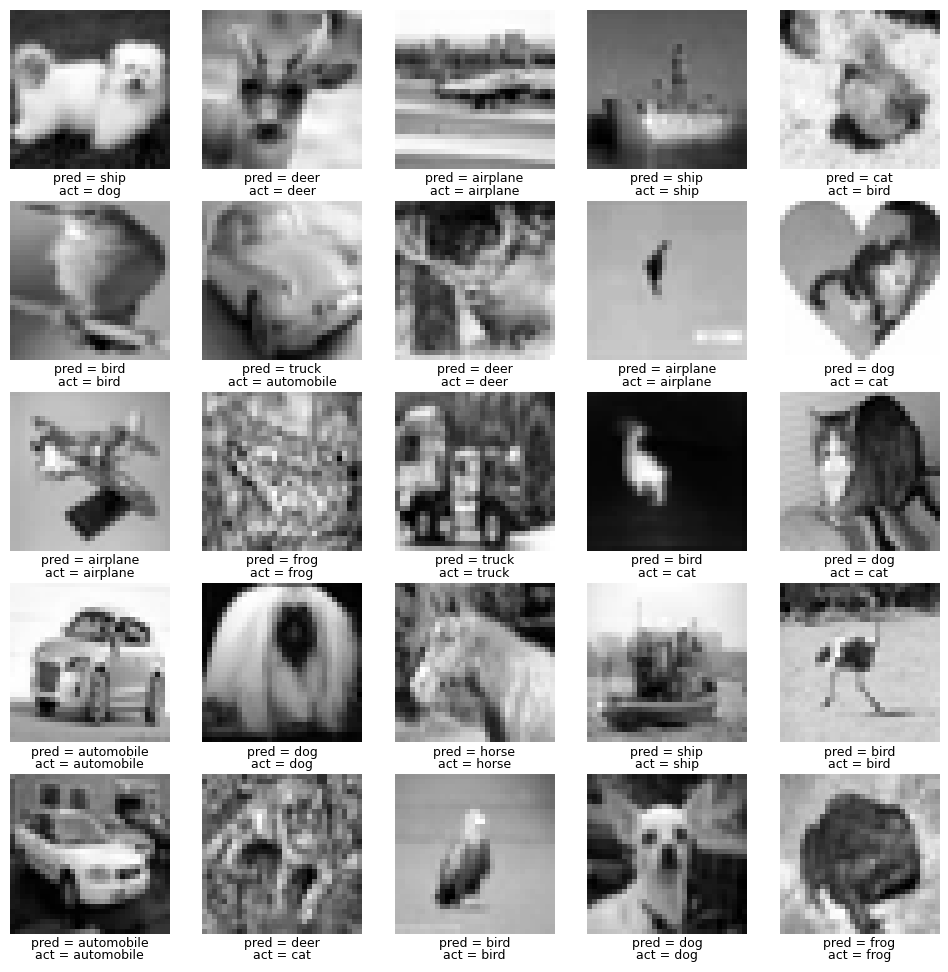

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for idx, ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.text(0.5, -0.08, 'pred = ' + pred[idx], fontsize=9, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.16, 'act = ' + actual[idx], fontsize=9, ha='center', transform=ax.transAxes)
    ax.imshow(test_batch['image'][idx, ..., 0], cmap='gray')
    ax.axis('off')